In [8]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd
import random
from scipy.optimize.minpack import leastsq
from diffpy.Structure import loadStructure
from diffpy.srfit.pdf import PDFContribution
from diffpy.srfit.fitbase import FitRecipe, FitResults
import shutil
import os
import fnmatch

In [16]:
os.chdir('/Users/dimitrygrebenyuk/Yandex.Disk.localized/Working/PDF/Refinements/ThO2/fits/dataset_10/MC_th14plus3drop2')

In [17]:
dataFile = "Th22_10_spot2_0001_0000_summed_bsub_tmean.gr"
basename = 'th14plus3drop2'

In [18]:
def PDF_fit(structure, data, qmin, qmax, qdamp, qbroad, xmin, xmax, scale, d, zoomscale, run_number):
    cdsePDF = PDFContribution("CdSe")
    cdsePDF.loadData(data)
    cdsePDF.setCalculationRange(xmin=xmin, xmax=xmax, dx=0.01)
    cdseStructure = loadStructure(f'{structure}.xyz')
    cdsePDF.addStructure("CdSe", cdseStructure, periodic=False)
    cdseFit = FitRecipe()
    cdseFit.addContribution(cdsePDF)
    cdsePDF.CdSe.setQmin(qmin)
    cdsePDF.CdSe.setQmax(qmax)
    cdsePDF.CdSe.qdamp.value = qdamp
    cdsePDF.CdSe.qbroad.value = qbroad

    cdseFit.addVar(cdsePDF.scale, scale, tag='scale', fixed=False)
    cdseFit.addVar(cdsePDF.CdSe.delta1, d, tag='d1', fixed=True)
    zoomscale = cdseFit.newVar('zoomscale', value=zoomscale, tag='zoomscale')
    lattice = cdsePDF.CdSe.phase.getLattice()
    cdseFit.constrain(lattice.a, zoomscale)
    cdseFit.constrain(lattice.b, zoomscale)
    cdseFit.constrain(lattice.c, zoomscale)
    ThUiso = cdseFit.newVar("Ho_Uiso", value=3.12000000e-02, tag='adp', fixed=True)
    OUiso = cdseFit.newVar("O_Uiso", value=1.16000000e-01, tag='adp', fixed=True)
    atoms = cdsePDF.CdSe.phase.getScatterers()
    for atom in atoms:
        if atom.element == 'Th':
            cdseFit.constrain(atom.Uiso, ThUiso)
        elif atom.element == 'O':
            cdseFit.constrain(atom.Uiso, OUiso)

    cdseFit.clearFitHooks()

    leastsq(cdseFit.residual, cdseFit.values)
    
    cdseStructure.write(f'{structure}.xyz', "xyz")
    profile = cdseFit.CdSe.profile
    profile.savetxt(f'{structure}.fit')


def calculate_rmsd(profile_fit):
    data = pd.read_csv(profile_fit, delim_whitespace=True, index_col=False)
    data.columns = ['a', 'b', 'c', 'd', 'e']
    df = pd.DataFrame(data)
    experimental = df.c.to_numpy()
    calculated = df.b.to_numpy()
    return np.sqrt(((experimental-calculated)**2).mean())

def monte_carlo_step(structure, l):

    with open(f'{structure}.xyz', 'r') as f:
        lines = f.readlines()

    displacement = np.random.uniform(-1, 1, 3*(len(lines)-3))
    norm = np.linalg.norm(displacement)
    displacement = displacement / norm * l
    displacement = np.array_split(displacement, (len(lines)-3))

    new_lines = [lines[0], lines[1]]
    for i, line in enumerate(lines[2:]):
        fields = line.split()
        k = i%len(displacement)
        line = (
            f'{fields[0]} {str(float(fields[1]) + displacement[k][0])} {str(float(fields[2]) + displacement[k][1])} {str(float(fields[3]) + displacement[k][2])}'
            + "\n"
        )
        new_lines.append(line)

    with open(f'{structure}.xyz', 'w') as f:
        f.writelines(new_lines)


def monte_carlo(steps, structure, data, qmin, qmax, qdamp, qbroad, 
xmin, xmax, scale, d, zoomscale, initial_l, cooling_rate, run_number):
    
    PDF_fit(structure, data, qmin, qmax, qdamp, qbroad, xmin, xmax, scale, d, zoomscale, run_number)
    best_rmsd = calculate_rmsd(f'{structure}.fit')
    shutil.copyfile(f'{structure}.xyz', f'{structure}_MC.xyz')
    print(f'Initial RMSD value for run {run_number} is {best_rmsd:.4f}')
    l = initial_l
    rmsd_values = []
    l_values = []

    #fig, ax1 = plt.subplots(figsize=(10,7))
    #ax1.set_xlabel("Iteration", fontsize=14)
    #ax1.set_ylabel("RMSD", fontsize=14)
    #ax1.set_title("RMSD vs Iterations", fontsize=14)
    #ax1.tick_params(axis='both', which='major', labelsize=12)

    #def online_plot():
    #    ax1.plot(range(i+1), rmsd_values, color='red')
    #    ax1.set_xlim(0, steps)
    #    ax1.set_ylim(min(rmsd_values), max(rmsd_values))
    #    fig.canvas.draw()
    #    plt.pause(0.01)
    #    return None

    for _ in range(steps):
        monte_carlo_step(structure, l)
        PDF_fit(structure, data, qmin, qmax, qdamp, qbroad, xmin, xmax, scale, d, zoomscale, run_number)
        rmsd = calculate_rmsd(f'{structure}.fit')
        rmsd_values.append(rmsd)
        l_values.append(l)
        if rmsd < best_rmsd:
            best_rmsd = rmsd
            shutil.copyfile(f'{structure}.xyz', f'{structure}_MC.xyz')
            l = initial_l
        else:
            shutil.copyfile(f'{structure}_MC.xyz',f'{structure}.xyz')
            l *= cooling_rate    

    print(f'Best RMSD value for run {run_number} is {best_rmsd:.4f}')

    return rmsd_values, l_values

def plot_rmsd_l_values(all_rmsd_values, all_l_values):
    fig, ax1 = plt.subplots(figsize=(10,7))
    ax1.set_xlabel("MC Run Number", fontsize=14)
    ax1.set_ylabel("RMSD", fontsize=14)
    ax1.set_title("RMSD vs MC Run Number", fontsize=14)
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax1.scatter(range(1, len(all_rmsd_values)+1), all_rmsd_values, color='red', s=20)
    ax1.set_xlim(1, len(all_rmsd_values))
    #ax1.set_ylim(min(all_rmsd_values), max(all_rmsd_values))
    #ax2 = ax1.twinx()
    #ax2.set_ylabel("l value", fontsize=14)
    #ax2.plot(range(1, len(all_l_values)+1), all_l_values, color='blue')
    #ax2.set_ylim(min(all_l_values), max(all_l_values))
    plt.show()

def random_displacement(structure, initial_displacement):
    with open(f'{structure}.xyz', 'r') as f:
        lines = f.readlines()

    displacement = np.random.uniform(-1, 1, 3*(len(lines)-3))
    norm = np.linalg.norm(displacement)
    displacement = displacement / norm * initial_displacement
    displacement = np.array_split(displacement, (len(lines)-3))

    new_lines = [lines[0], lines[1]]
    for i, line in enumerate(lines[2:]):
        fields = line.split()
        k = i%len(displacement)
        line = (
            f'{fields[0]} {str(float(fields[1]) + displacement[k][0])} {str(float(fields[2]) + displacement[k][1])} {str(float(fields[3]) + displacement[k][2])}'
            + "\n"
        )
        new_lines.append(line)

    with open(f'{structure}.xyz', 'w') as f:
        f.writelines(new_lines)
    return

def monte_carlo_multiple_starts(n_runs, steps, structure, 
data, qmin, qmax, qdamp, qbroad, xmin, xmax, scale, d, zoomscale, 
initial_l, cooling_rate):
    all_rmsd_values = []
    all_l_values = []
    for run in range(n_runs):
        shutil.copyfile(f'{structure}.xyz', f'{structure}_start{run}.xyz')
        structure_start = f'{structure}_start{run}'
        random_displacement(structure_start, 0.1)
        rmsd_values, l_values = monte_carlo(steps, structure_start, data, qmin, qmax, qdamp, qbroad, xmin, xmax, scale, d, zoomscale, initial_l, cooling_rate, run)
        all_rmsd_values.extend(rmsd_values)
        all_l_values.extend(l_values)
        best_rmsd = min(rmsd_values)
        best_structure_index = rmsd_values.index(best_rmsd)
        shutil.copyfile(f'{structure}_start{run}_MC.xyz', f'{structure}_MC_run{run}_bestRMSD_{best_rmsd:.4f}.xyz')
    return all_rmsd_values, all_l_values

def clean_files(pattern):
    for file in os.listdir('.'):
        if fnmatch.fnmatch(file, pattern):
            file_path = os.path.join('.', file)
            try:
                if os.path.isfile(file_path):
                    os.unlink(file_path)
            except Exception as e:
                print(f'Failed to delete {file_path}. Reason: {e}')

In [19]:
clean_files('*start*')
clean_files('*run*')
clean_files(f'{basename}.xyz')
clean_files(f'{basename}_MC.xyz')
clean_files(f'{basename}.fit')

Initial RMSD value for run 0 is 0.3714
Best RMSD value for run 0 is 0.2283
Initial RMSD value for run 1 is 0.3706
Best RMSD value for run 1 is 0.2323
Initial RMSD value for run 2 is 0.3717
Best RMSD value for run 2 is 0.2390
Initial RMSD value for run 3 is 0.3718
Best RMSD value for run 3 is 0.2175
Initial RMSD value for run 4 is 0.3714
Best RMSD value for run 4 is 0.2197
Initial RMSD value for run 5 is 0.3705
Best RMSD value for run 5 is 0.2152
Initial RMSD value for run 6 is 0.3722
Best RMSD value for run 6 is 0.2149
Initial RMSD value for run 7 is 0.3705
Best RMSD value for run 7 is 0.2187
Initial RMSD value for run 8 is 0.3705
Best RMSD value for run 8 is 0.2118
Initial RMSD value for run 9 is 0.3717
Best RMSD value for run 9 is 0.2362
Initial RMSD value for run 10 is 0.3727
Best RMSD value for run 10 is 0.2211
Initial RMSD value for run 11 is 0.3716
Best RMSD value for run 11 is 0.2294
Initial RMSD value for run 12 is 0.3709
Best RMSD value for run 12 is 0.2079
Initial RMSD value 

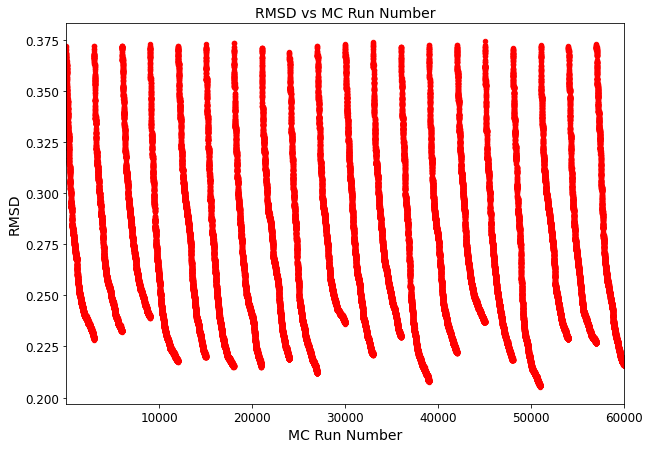

In [20]:
%matplotlib inline

shutil.copyfile(f'{basename}_init.xyz', f'{basename}.xyz')  

all_rmsd_values, all_l_values = monte_carlo_multiple_starts(n_runs=20, steps=3000, structure=basename, 
data=dataFile, qmin=1, qmax=21, qdamp=0.02, qbroad=0.02, xmin=1.7, xmax=20,
scale=9.20987170e-01, d=2.2107, zoomscale=1.0,
initial_l=0.1, cooling_rate=0.9)

plot_rmsd_l_values(all_rmsd_values=all_rmsd_values, all_l_values=all_l_values)

In [ ]:
# This function performs a single run of MC simulation
#%matplotlib notebook
filepath = '/Users/dimitrygrebenyuk/Yandex.Disk.localized/Working/PDF/Refinements/ML-MotEx/clusters/th40/fit_from_ML/MC/th10_ML.xyz'
filepath2 = '/Users/dimitrygrebenyuk/Yandex.Disk.localized/Working/PDF/Refinements/ML-MotEx/clusters/th40/fit_from_ML/MC/th10_ML_MC.xyz'
if os.path.exists(filepath):
    os.remove(filepath)
if os.path.exists(filepath2):
    os.remove(filepath2)
shutil.copyfile('th10_ML_init.xyz','th10_ML.xyz')  

monte_carlo(steps=50, 
structure='th10_ML', data=dataFile, qmin=1, qmax=21, 
qdamp=0.02, qbroad=0.02, xmin=1.7, xmax=20,
scale=8.46637153e-01, d=2.159, zoomscale=1.0397,
initial_l=0.1, cooling_rate=0.9, run_number=0)

In [ ]:
# This function looks OK but it won't work with the current implementation of the monte_carlo() function.

def run_mc_simulation(initial_config, num_configs, displacement, steps, 
data, qmin, qmax, qdamp, qbroad, xmin, xmax, scale, d, zoomscale, 
initial_l, cooling_rate, basename):

    for i in range(num_configs):
        shutil.copyfile(initial_config, f'{basename}_{i}.xyz')
        with open(f'{basename}_{i}.xyz', 'r+') as structure:
            atoms = structure.readlines()[2:]
            for j in range(len(atoms)):
                atoms[j] = atoms[j].split()
                atoms[j][1] = str(float(atoms[j][1]) + random.uniform(-displacement, displacement))
                atoms[j][2] = str(float(atoms[j][2]) + random.uniform(-displacement, displacement))
                atoms[j][3] = str(float(atoms[j][3]) + random.uniform(-displacement, displacement))
                atoms[j] = ' '.join(atoms[j]) + '\n'
            structure.seek(0)
            structure.write(f'{len(atoms)}\n\n')
            structure.writelines(atoms)
        monte_carlo(steps, f'{basename}_{i}.xyz', data, qmin, qmax, qdamp, qbroad, xmin, xmax, scale, d, zoomscale, initial_l, cooling_rate)
        shutil.copyfile(f'{basename}.fit', f'{basename}_{i}_best.xyz')